In [ ]:
# Libraries needed 
pip install docplex # CPLEX solver
pip install qiskit
pip install qiskit_aer 
pip install openqaoa-core


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import copy
from docplex.mp.model import Model
import networkx as nx
import itertools


from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.circuit import ParameterVector

from openqaoa.problems import FromDocplex2IsingModel

backend = Aer.get_backend("qasm_simulator")

In [3]:
def MaxCut(G):
    """
    Input:
        G: Networkx graph
    Output:
        mdl: Docplex model
    """
    # MIS model as a QUBO problem
    mdl = Model('MaxCut')
    num_vertices = G.number_of_nodes()
    x = {i: mdl.binary_var(name=f"x_{i}") for i in range(num_vertices)}
    cost = 0
    for i, j in G.edges:
        if nx.is_weighted(G):
            cost += - G[i][j]["weight"] * (x[i] * (1 - x[j]) + x[j] * (1 - x[i]))
        else:
            cost += - (x[i] * (1 - x[j]) + x[j] * (1 - x[i]))
    mdl.minimize(cost)
    return mdl

def cost_maxcut(bitstring, weights):
    cost = 0
    for i, j in weights.keys():
        if bitstring[i] + bitstring[j] in ["10","01"]:
            cost += weights[i,j]
    return cost

def objective_MaxCut(samples_dict, G, optimal_solution):
    if nx.is_weighted(G):
        weights = {(i,j):(G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}
    else:
        weights = {(i,j):(G[i][j] if len(G[i][j]) != 0 else 1) for i, j in G.edges}
    optimal_cost = cost_maxcut(optimal_solution, weights)
    results = []
    probability = 0
    for bitstring, counts in samples_dict.items():
        cost = cost_maxcut(bitstring, weights)
        r  = cost / optimal_cost
        if np.abs(cost - optimal_cost) < 1e-8: # If the approximation ratio is 1 means the bitstring is the optimal solution
            probability += counts
        if optimal_cost - cost < 0:
            print(f"There is a better cost than that of CPLEX by {optimal_cost - cost}!")
        results.append([cost, r, counts])
    results = np.array(results)
    shots = np.sum(results[:,2])
    mean_r = np.sum(results[:,0] * results[:,2])/(shots * optimal_cost)
    probability /= shots
    return {"results":np.array(results), "optimal_cost":optimal_cost, "r":mean_r, "probability":probability}

def qaoa_circ(hamiltonian, gammas, betas, n_qubits, shots):
    p = len(gammas)
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    for ii in range(p):
        for qbits, value in hamiltonian.items():
            if len(qbits) == 1:
                qc.rz(2*gammas[ii]*float(value), qbits[0])
        for qbits, value in hamiltonian.items():
            if len(qbits) == 2:
                qc.rzz(2*gammas[ii]*float(value), *qbits)
        qc.rx(-2*betas[ii], range(n_qubits))
    qc = qc.reverse_bits()
    qc.measure_all()
    probs = backend.run(qc, shots=shots).result().get_counts()
    return probs

def mitigated(samples, G, hamming=1):
    weights = {(i,j):(G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}
    change = {"0":"1", "1":"0"}
    new_samples = defaultdict(int)
    nq = G.number_of_nodes()
    combinations = list(itertools.combinations(range(nq), hamming))
    for string, count in samples.items():
        best_cost = cost_maxcut(string, weights)
        best_string = string
        for comb in combinations:
            new_string = "".join((change[i] if n in comb else i) for n, i in enumerate(string))
            new_cost = cost_maxcut(new_string, weights)
            if new_cost >= best_cost:
                best_string = new_string
                best_cost = new_cost
        new_samples[best_string] += count
    return new_samples

def random_sampler(num_samples, n_qubits):
    random_samples = defaultdict(int)
    for i in range(num_samples):
        random_samples["".join(str(i) for i in np.random.choice([0,1], n_qubits))] += 1
    return random_samples

# W-MaxCut problems

# $p = N_q$

In [4]:
np.random.seed(1)
nodes_list_qubo = range(5, 26)
random_cases = 10
prob = 1
problems = {}
# Generate graphs with the above condition for different number of nodes
for nodes in nodes_list_qubo: 
    print(f"number of nodes {nodes}")
    problems[nodes] = {}
    for kk in range(random_cases):
        problems[nodes][kk] = defaultdict(dict)
        G = nx.Graph()
        G.add_nodes_from(range(nodes))
        for i in range(nodes - 1):
            for j in range(i+1, nodes):
                if np.random.rand() < prob:
                    w = round(np.random.rand(), 3)
                    G.add_weighted_edges_from([[i,j,w]])
        problems[nodes][kk]["G"] = G
        mdl = MaxCut(G)
        problems[nodes][kk]["qubo"] = MaxCut(G)
        mdl.solve() # solve the problem using CLPEX
        problems[nodes][kk]["n_iterations_cplex"] = mdl.get_solve_details().nb_iterations
        problems[nodes][kk]["time_cplex"] = mdl.get_solve_details().deterministic_time
        problems[nodes][kk]["real_time_cplex"] = mdl.get_solve_details().time
        problems[nodes][kk]["sol"] = "".join(str(round(mdl.solution.get_value(var))) for var in mdl.iter_binary_vars())
        problems[nodes][kk]["ising_hamiltonian"] = FromDocplex2IsingModel(mdl).ising_model

number of nodes 5


number of nodes 6
number of nodes 7
number of nodes 8
number of nodes 9
number of nodes 10
number of nodes 11
number of nodes 12
number of nodes 13
number of nodes 14
number of nodes 15
number of nodes 16
number of nodes 17
number of nodes 18
number of nodes 19
number of nodes 20
number of nodes 21
number of nodes 22
number of nodes 23
number of nodes 24
number of nodes 25


In [5]:
shots = 10000
delta_beta = 0.5
delta_gamma = 0.5

for nq in problems.keys():
    if nq > 25:
        break
    print(f"-------- nq: {nq} ------------")
    for case in problems[nq].keys():
        problems[nq][case]["shots"] = shots
        ising_hamiltonian = problems[nq][case]["ising_hamiltonian"]
        max_weight = max(ising_hamiltonian.weights) # Normalization
        hamiltonian = {tuple(i) : w / max_weight for i, w in zip(ising_hamiltonian.terms, ising_hamiltonian.weights) if abs(w) > 1e-9}
        p = nq # The number of qubits equal to the number of layers in QAOA
        gammas = np.arange(1, p+1) * delta_gamma/p
        betas = np.arange(1, p+1)[::-1] * delta_beta/p
        problems[nq][case]["samples"] = qaoa_circ(hamiltonian, gammas, betas, nq, shots)
        problems[nq][case]["results"] = objective_MaxCut(problems[nq][case]["samples"],
                                                            problems[nq][case]["G"],
                                                            problems[nq][case]["sol"])
        problems[nq][case]["samples_mitig"] = mitigated(problems[nq][case]["samples"], problems[nq][case]["G"])
        problems[nq][case]["results_mitig"] = objective_MaxCut(problems[nq][case]["samples_mitig"],
                                                                    problems[nq][case]["G"],
                                                                    problems[nq][case]["sol"])
np.save("./Data/WMaxCut_cte.npy", problems)

-------- nq: 5 ------------
-------- nq: 6 ------------
-------- nq: 7 ------------
-------- nq: 8 ------------
-------- nq: 9 ------------
-------- nq: 10 ------------
-------- nq: 11 ------------
-------- nq: 12 ------------
-------- nq: 13 ------------
-------- nq: 14 ------------
-------- nq: 15 ------------
-------- nq: 16 ------------
-------- nq: 17 ------------
-------- nq: 18 ------------
-------- nq: 19 ------------
-------- nq: 20 ------------
-------- nq: 21 ------------
-------- nq: 22 ------------
-------- nq: 23 ------------
-------- nq: 24 ------------
-------- nq: 25 ------------


In [19]:
problems = np.load("WMaxCut_cte.npy", allow_pickle=True).item()


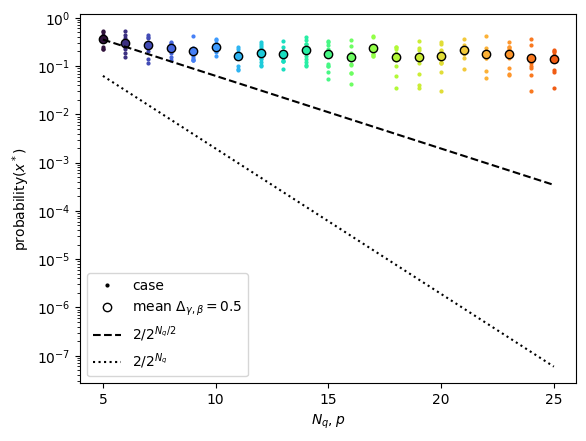

In [20]:
fig, ax = plt.subplots()
colors=plt.get_cmap("turbo")
nqs = list(problems.keys())
nq_min = 5
nq_max = 30
nqs = np.arange(5, 26)
for nq in nqs:
    ax.plot(len(problems[nq])*[nq], [problems[nq][case]["results"]["probability"] for case in problems[nq].keys()], marker="o", linewidth=0, markersize=2, color=colors((nq-nq_min)/(nq_max-nq_min)))
for nq in nqs:
    ax.plot([nq], np.mean([problems[nq][case]["results"]["probability"] for case in problems[nq].keys()]), marker="o", linewidth=0, markeredgecolor="black", color=colors((nq-nq_min)/(nq_max-nq_min)), markersize=6)
ax.plot([], [], marker="o", linewidth=0, markersize=2, color="black", label="case")
ax.plot([], [], marker="o", linewidth=0, markeredgecolor="black", color="white", markersize=6, label =r"mean $\Delta_{\gamma,\beta}=0.5$")
ax.plot(nqs, [2/2**(i/2) for i in nqs], color="black", linestyle="--", label=r"$2/2^{N_q/2}$")
ax.plot(nqs, [2/2**(i) for i in nqs], color="black", linestyle=":", label=r"$2/2^{N_q}$")

ax.set_ylabel(r"probability($x^*$)")
ax.set_xlabel(r"$N_q,p$")
ax.set_yscale("log")
ax.set_xticks([5,10,15,20,25])
ax.legend()
# fig.savefig("probability_WMaxCut_LRQAOA.pdf", transparent=True, bbox_inches="tight")

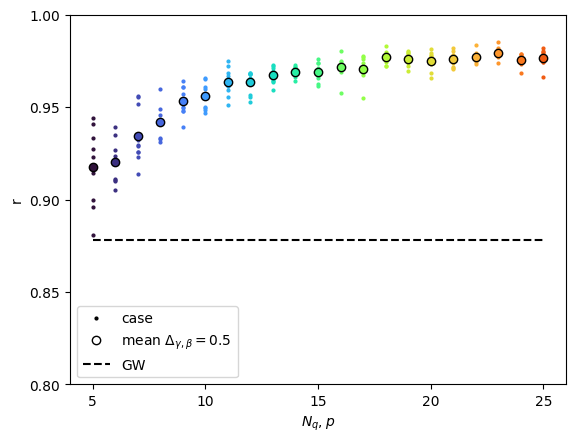

In [21]:
fig, ax = plt.subplots()
colors=plt.get_cmap("turbo")
nqs = list(problems.keys())
nq_min = 5
nq_max = 30
nqs = np.arange(5, 26)
for nq in nqs:
    ax.plot(len(problems[nq])*[nq], [problems[nq][case]["results"]["r"] for case in problems[nq].keys()], marker="o", linewidth=0, markersize=2, color=colors((nq-nq_min)/(nq_max-nq_min)))
for nq in nqs:
    ax.plot([nq], np.mean([problems[nq][case]["results"]["r"] for case in problems[nq].keys()]), marker="o", linewidth=0, markeredgecolor="black", color=colors((nq-nq_min)/(nq_max-nq_min)))
ax.plot([], [], marker="o", linewidth=0, markersize=2, color="black", label="case")
ax.plot([], [], marker="o", linewidth=0, markeredgecolor="black", color="white", markersize=6, label =r"mean $\Delta_{\gamma,\beta}=0.5$")
ax.plot([5, 25], [0.878, 0.878], color="black", linestyle="--", label=r"GW")

ax.set_ylabel("r")
ax.set_xlabel(r"$N_q, p$")
ax.set_xticks([5,10,15,20,25])
ax.set_yticks([0.8, 0.85, 0.9, 0.95, 1])
ax.legend()
# fig.savefig("WMaxCut_LRQAOA_r.pdf", transparent=True, bbox_inches="tight")